In [23]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from scipy.ndimage import gaussian_filter1d

In [24]:
# read files
df_money = pd.read_pickle("../data/cleaned/by_id_verified_money_2020-2021.pkl")
df_tweet = pd.read_pickle("../data/cleaned/tweets_verified_2020-2021_cleaned.pkl")
df_bitcoin = pd.read_csv("../data/raw/bitcoin_value_2020-2021.csv", parse_dates=["datetime"])

# get differential of bitcoin value
df_bitcoin['diff'] = df_bitcoin['close_bitcoin'].diff()

In [25]:
# merge tweets and sentiment values
df_tweet_money = pd.merge(df_tweet, df_money, how='left', on='id')
df_tweet_money['money'] = df_tweet_money['money'].fillna(0)

# sum metrics
df_tweet_money['sum_metrics'] = df_tweet_money['replies_count'] + \
                                    df_tweet_money['retweets_count'] + \
                                    df_tweet_money['likes_count']

# get weights
df_freq = df_tweet_money.groupby(['sum_metrics']).agg({'id':'count'}).reset_index()
df_freq = df_freq.rename(columns={'id': 'freq_tweets'})

freq_max = df_freq['freq_tweets'].max()
freq_min = df_freq['freq_tweets'].min()

df_freq['freq_tweets_norm'] = (df_freq['freq_tweets'] - freq_min) / (freq_max - freq_min)
df_freq['weights'] = 1 - df_freq['freq_tweets_norm']

display(df_freq)

,sum_metrics,freq_tweets,freq_tweets_norm,weights
0,0,28660,1.000000,0.000000
1,1,26524,0.925468,0.074532
2,2,20857,0.727730,0.272270
3,3,15447,0.538958,0.461042
4,4,12001,0.418717,0.581283
...,...,...,...,...
7429,322701,1,0.000000,1.000000
7430,384178,1,0.000000,1.000000
7431,688122,1,0.000000,1.000000
7432,1010436,1,0.000000,1.000000


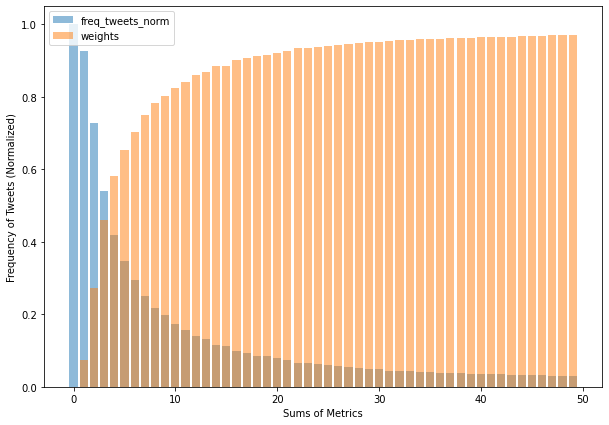

In [26]:
_ = plt.figure(figsize=(10, 7))

_ = plt.bar(df_freq['sum_metrics'][0:50], df_freq['freq_tweets_norm'][0:50], label='freq_tweets_norm', alpha=0.5)
_ = plt.bar(df_freq['sum_metrics'][0:50], df_freq['weights'][0:50], label='weights', alpha=0.5)

_ = plt.legend()
_ = plt.xlabel("Sums of Metrics")
_ = plt.ylabel("Frequency of Tweets (Normalized)")

_ = plt.savefig("figures/sum_metr_vs_freq.svg", format='svg')
_ = plt.show()

In [27]:
# merge weights with 
df = pd.merge(df_tweet_money,\
              df_freq[['sum_metrics', 'weights']], \
              how='left', \
              on='sum_metrics')

# get weighted sentiments
df['weighted_money'] = df['money'] * df['weights']

display(df[['money', 'sum_metrics', 'weights', 'weighted_money']].head())

,money,sum_metrics,weights,weighted_money
0,0.0,433,0.998395,0.000000
1,0.0,10,0.825674,0.000000
2,2015.0,4,0.581283,1171.285983
3,2020.0,185,0.994138,2008.158694
4,9478.0,0,0.000000,0.000000


In [28]:
# group by date and get the mean of weighted_sentiment
df_by_date = df.groupby(df['created_at'].dt.date).agg({'weighted_money': 'mean'}).reset_index()

display(df_by_date.head())

,created_at,weighted_money
0,2020-01-01,879.738575
1,2020-01-02,361.993070
2,2020-01-03,332.667183
3,2020-01-04,101.977001
4,2020-01-05,202.831361


In [41]:
# clean data before export
df_by_date["created_at"] = pd.to_datetime(df_by_date["created_at"])
df_by_date = df_by_date.rename(columns={'created_at': 'datetime'})

In [48]:
df_merged_bydate = pd.merge(df_by_date,
                       df_bitcoin,
                       how = "left",
                       left_on = "datetime",
                       right_on = "datetime")

df_merged_bydate['normalized_money'] = \
    (df_merged_bydate['weighted_money'] - df_merged_bydate['open'])\
    / df_merged_bydate['open']

df_merged_bydate.head()

,datetime,weighted_money,Unnamed: 0,volume,open,high,low,close_bitcoin,close_eth,close_bnb,close_ada,value_number_transaction,value_number_address,value_transaction_second,value_total_bitcoin,value_volume_trade,value_hash_rate,diff,normalized_money
0,2020-01-01,879.738575,0,31951.483932,7200.77,7212.50,6924.74,6965.71,127.19,13.0105,0.03269,295567.0,475461.0,3.156424,1.813511e+07,2.860097e+07,9.671772e+07,NaN,-0.877827
1,2020-01-02,361.993070,1,68428.500451,6965.49,7405.00,6871.04,7344.96,134.35,13.6474,0.03417,316517.0,523231.0,2.839931,1.813689e+07,6.828297e+07,1.159241e+08,379.25,-0.948030
2,2020-01-03,332.667183,2,29987.974977,7345.00,7404.00,7272.21,7354.11,134.20,13.8092,0.03434,287215.0,465366.0,3.339583,1.813869e+07,1.368703e+08,1.152381e+08,9.15,-0.954708
3,2020-01-04,101.977001,3,38331.085604,7354.19,7495.00,7318.00,7358.75,135.37,14.0532,0.03460,287779.0,459065.0,3.481424,1.814046e+07,5.018183e+07,1.118084e+08,4.64,-0.986133
4,2020-01-05,202.831361,4,54635.695316,7357.64,7795.34,7346.76,7758.00,144.15,14.9471,0.03732,299146.0,522665.0,3.192535,1.814225e+07,4.817756e+07,9.260207e+07,399.25,-0.972433


In [ ]:
# export as pickle
df_by_date.to_pickle("../data/cleaned/by_date_verified_weighted_money_2020-2021.pkl")

In [ ]:
# try reading pickle
df_test = pd.read_pickle("../data/cleaned/by_date_verified_weighted_money_2020-2021.pkl")

display(df_test.dtypes)
display(df_test.head())

In [ ]:
def plot_sent_vs_bit(from_date, to_date, sigma, save_to=None):
    fig, ax1 = plt.subplots(figsize=(10, 7))

    _ = ax1.set_xlabel("Time (Month)")
    lns1 = ax1.plot(df_by_date['created_at'],
                    gaussian_filter1d(df_by_date['weighted_money'], sigma), 
                    color='blue',
                    label='Weighted Money')
    _ = ax1.set_ylabel("Weighted Money")

    ax2 = ax1.twinx()
    lns2 = ax2.plot(df_bitcoin['datetime'],
                    gaussian_filter1d(df_bitcoin['diff'], sigma),
                    color='orange',
                    label='Diff. Bitcoin')
    _ = ax2.set_ylabel("Diff. Bitcoin Value (Dollar)")

    lns = lns1 + lns2
    labs = [l.get_label() for l in lns]
    _ = ax1.legend(lns, labs, loc=3)
    _ = ax1.set_xlim(pd.Timestamp(from_date), pd.Timestamp(to_date))

    if save_to is not None:
        _ = plt.savefig(save_to, format='svg')
    _ = plt.show()

In [ ]:
# plot weighted sentiment vs diff. bitcoin value
plot_sent_vs_bit('2020-01-01', '2021-12-31', 5)

In [ ]:
# plot weighted sentiment vs diff. bitcoin value (2021 only)
plot_sent_vs_bit('2021-01-01', '2021-12-31', 5, "figures/")